## Demonstrating functions for Reynolds scales project

**To-do**
1. Read Chuychai in more detail, possibly including the cited paper/s, to confirm the extrapolation method
2. Make note of ion inertial length:

$$d_i=c/\omega_{i}=V_A/\Omega_I=?/\sqrt{n_e}$$

- $\omega_{p_i}$ is the ion plasma gyrofrequency
- $\Omega_I$ is the ion gyrofrequency
- $n_e$ is the local electron density
- $V_A$ is the Alfven speed


3. Create OMNI .py script
4. Create method that makes a plot of some raw data before re-sampling
4. Perform correction factor
4. Walk thru notebook with Tulasi
4. Put into .py script
5. Run on full data

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy
from scipy.optimize import curve_fit
import statsmodels.api as sm

while ".toplevel" not in os.listdir():
    os.chdir("..")

from utils import pipeline, print_cdf_info, join_dataframes_on_timestamp, read_cdf

#### Reading in Omni data

6-hour averages

In [2]:
df_omni = pd.read_pickle("data/processed/omni_6hr.pkl")

In [3]:
df_omni.head()

,proton_density,T,flow_speed,Beta,Pressure,E
Timestamp,,,,,,
2022-03-01 00:00:00,2.467332,143880.421875,485.035278,1.004819,1.174217,0.382646
2022-03-01 06:00:00,2.883498,158896.921875,512.843018,1.593343,1.536808,0.546662
2022-03-01 12:00:00,2.780694,154286.343750,532.394287,2.020681,1.577736,0.557903
2022-03-01 18:00:00,2.655195,120716.070312,505.969574,1.840625,1.363750,0.202918
2022-03-02 00:00:00,2.576718,109343.687500,486.376099,3.167181,1.219735,0.405748


array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>],
      dtype=object)

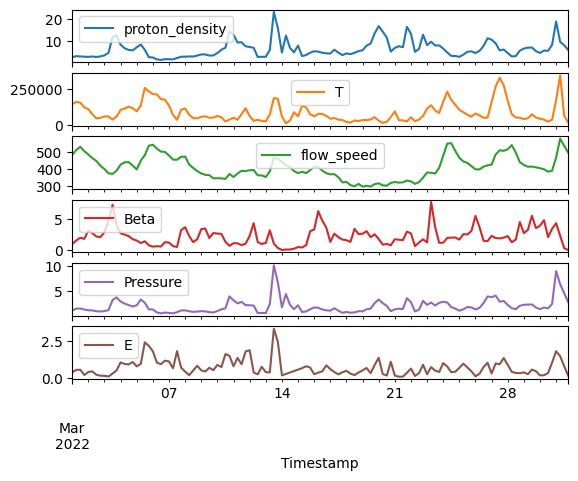

In [4]:
df_omni.plot(subplots=True)

### Reading in Wind data

#### Electron data
6-hour averages

In [5]:
electron_data = pd.read_pickle('data/processed/wi_elm2_3dp_6hr.pkl')
electron_data.head()

,DENSITY,AVGTEMP,VELOCITY_0,VELOCITY_1,VELOCITY_2
Timestamp,,,,,
2022-03-25 00:00:00,1.822326,15.172135,-544.932556,50.689743,-64.176735
2022-03-25 06:00:00,2.227258,12.905143,-484.040894,55.006096,-59.098175
2022-03-25 12:00:00,3.051863,11.594287,-477.494995,51.197334,-33.711304
2022-03-25 18:00:00,2.658205,12.316165,-484.791565,44.867531,-0.253989
2022-03-26 00:00:00,2.469755,12.783496,-459.578613,31.371471,3.734087


array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>], dtype=object)

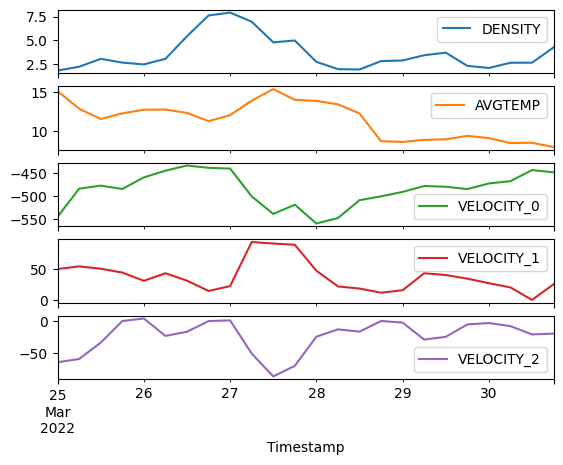

In [6]:
electron_data.plot(subplots=True)

#### Proton data

6-hour averages

In [7]:
proton_data = pd.read_pickle("data/processed/wi_plsp_3dp_6hr.pkl")
proton_data.head()

,MOM.P.DENSITY,MOM.P.AVGTEMP,MOM.P.VELOCITY_0,MOM.P.VELOCITY_1,MOM.P.VELOCITY_2
Timestamp,,,,,
2022-03-25 00:00:00,2.411639,18.348341,-480.596832,14.422548,-25.970224
2022-03-25 06:00:00,2.841534,14.684070,-456.271301,17.335016,-11.012655
2022-03-25 12:00:00,3.945019,12.897325,-444.065277,24.058189,2.999150
2022-03-25 18:00:00,3.534427,11.752072,-428.054688,26.754627,11.997001
2022-03-26 00:00:00,3.518609,12.768682,-407.992462,10.477046,21.004438


array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>], dtype=object)

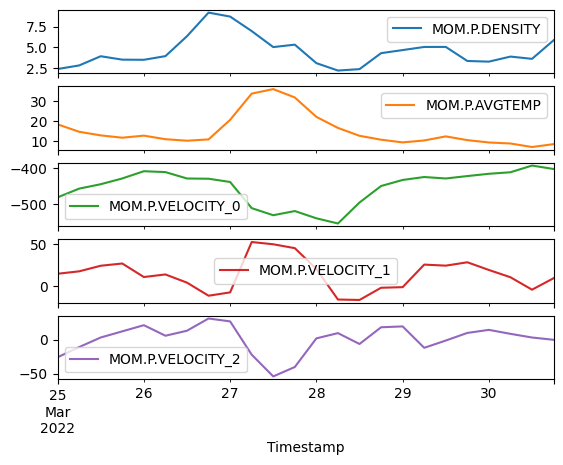

In [8]:
proton_data.plot(subplots=True)

#### Magnetic field data

**10Hz data**

In [9]:
large_wind_df_hr = pd.read_pickle("data/processed/wi_h2_mfi_hr.pkl")
large_wind_df_hr.head()

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2022-03-25 00:00:00.000,4.159470,-3.594954,0.446127,-2.044129
2022-03-25 00:00:00.100,4.166633,-3.610506,0.436836,-2.033287
2022-03-25 00:00:00.200,4.157491,-3.606513,0.402740,-2.028693
2022-03-25 00:00:00.300,4.178423,-3.616413,0.410756,-2.052330
2022-03-25 00:00:00.400,4.159176,-3.616791,0.378947,-2.018407


In [10]:
# Working with a single 6-hour interval
wind_df_hr = large_wind_df_hr["2022-03-25 12:00":"2022-03-25 18:00"]
wind_df_hr.shape

(216600, 4)

array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>],
      dtype=object)

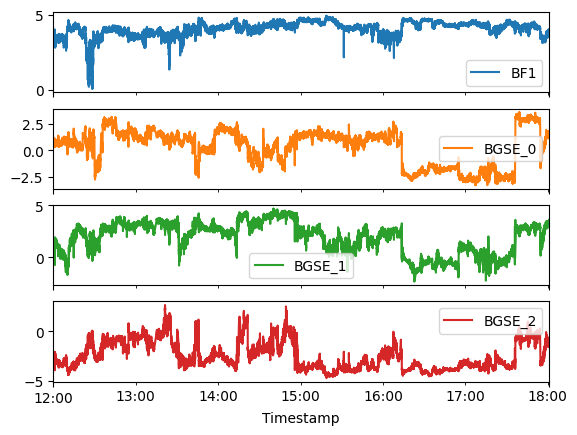

In [11]:
wind_df_hr.plot(subplots=True)

**0.2Hz data**

In [17]:
large_wind_df_lr = pd.read_pickle("data/processed/wi_h2_mfi_lr.pkl")
large_wind_df_lr.head()

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2022-03-25 00:00:00,4.165998,-3.569074,0.396649,-2.109345
2022-03-25 00:00:05,4.141199,-3.534857,0.415387,-2.112569
2022-03-25 00:00:10,4.117070,-3.528960,0.241816,-2.105574
2022-03-25 00:00:15,4.137564,-3.530582,0.238026,-2.143880
2022-03-25 00:00:20,4.136718,-3.553027,0.278456,-2.099380


In [20]:
# Working with a single 6-hour interval
wind_df_lr = large_wind_df_lr["2022-03-25 12:00":"2022-03-25 18:00"]
wind_df_lr.shape

(4332, 4)

array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>],
      dtype=object)

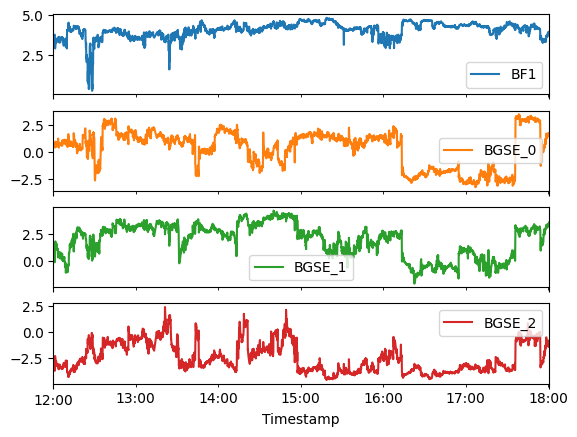

In [21]:
wind_df_lr.plot(subplots=True)

Now I will calculate the power spectrum and then fit a power law to the frequency range $2/t_{d_i}$ - $20/t_{d_i}$, where $t_{d_i}=d_{i}/v_{SW}$

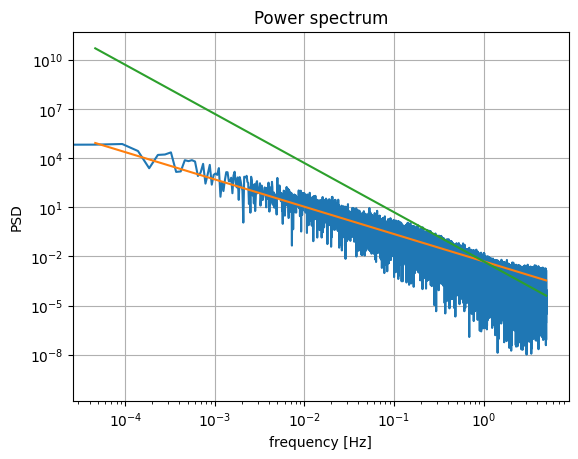

In [22]:
# Calculate 3D power spectrum
import scipy.signal as signal

x_freq = 10 # 10 Hz

# The power spectrum can be estimated directly, with the option of a window, using periodogram() 

f_periodogram, power_periodogram = signal.periodogram(wind_df_hr["BGSE_0"], fs = x_freq, window="boxcar", scaling="density")
power_periodogram = (x_freq/2)*power_periodogram # Correcting scaling

plt.semilogy(f_periodogram, power_periodogram)
plt.semilogy(f_periodogram[1:], 0.005*f_periodogram[1:]**(-5/3)) # Indexing so don't include 0 freq
plt.semilogy(f_periodogram[1:], 0.005*f_periodogram[1:]**(-3))
#plt.legend(['FFT', 'FFT w. window', 'Periodogram','Lomb-Scargle (scipy)', 'Welch', "FFT of ACF", "Lomb-Scargle (astropy)"])
plt.semilogx()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.title("Power spectrum")
plt.grid()
plt.show()


### ACF function

Based off Kevin's `compute_corr.compute_correlation_time_scale.compute_autocorrelation_function()`. Automatically detects whether being fed 1D (scalar) or 3D time series, for which the calculation is as follows:

$$R(\tau)=\frac{1}{3}\times(R_x(\tau)+R_y(\tau)+R_z(\tau))$$

- **NB: Taylor et al. calculated the ACF by first calculating the SF**
- *Should `tsa.acf()` be set to `fft=False`? Default is True. Check for differences in speed.*

In [23]:
def compute_nd_acf(np_array, nlags, dt, show=False):
    """ Compute the autocorrelation function for a scalar or vector time series.
    
    Args:

    - np_array: Array of shape (1,n) or (3,n)
    - nlags: The number of lags to calculate the ACF up to
    - dt: Cadence of measurements, or time between each sample: one sample every dt seconds

    Returns:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - R: The values of the ACF from lag 0 to nlags

    """
    if np_array.shape[0] == 3:
        acf = \
        sm.tsa.acf(np_array[0], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[1], fft=False, nlags=nlags) + \
        sm.tsa.acf(np_array[2], fft=False, nlags=nlags)
        acf /= 3

    elif np_array.shape[0] == 1:
        acf = sm.tsa.acf(np_array[0], fft=False, nlags=nlags)

    else:
        raise ValueError("Array is not 3D or 1D. If after a 1D acf, try putting square brackets around the pandas series in np.array()")

    time_lags = np.arange(0, nlags+1)*dt   

    # Optional plotting
    if show == True:

        fig, ax1 = plt.subplots()

        ax1.plot(time_lags, acf)
        ax2 = ax1.twiny()
        ax2.plot(np.arange(0, nlags+1), acf)

        ax1.set_xlabel('Lag (s)')
        ax2.set_xlabel('Lag ($\\tau$)')
        ax1.set_ylabel('Autocorrelation')
        plt.show()

    return time_lags, acf

Scalar version

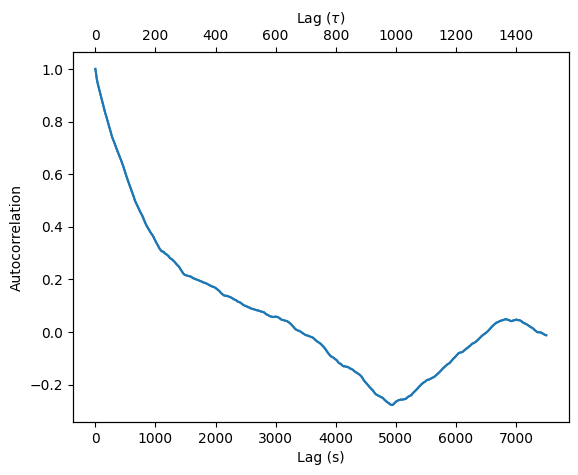

In [24]:
time_lags_lr, r_scalar_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0]), nlags=1500, dt = 5, show = True)

Vector version (same function, automatically detects). The following low-res ACF will be used for calculating the outer scale

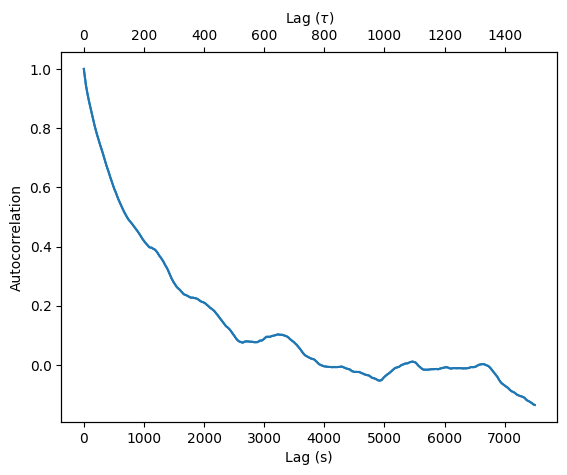

In [25]:
time_lags_lr, r_vec_lr = compute_nd_acf(np.array([wind_df_lr.BGSE_0, wind_df_lr.BGSE_1, wind_df_lr.BGSE_2]), nlags=1500, dt = 5, show = True)

The following high-res ACF will be used for calculating the Taylor scale. *This takes about 2.5 minutes to run*.

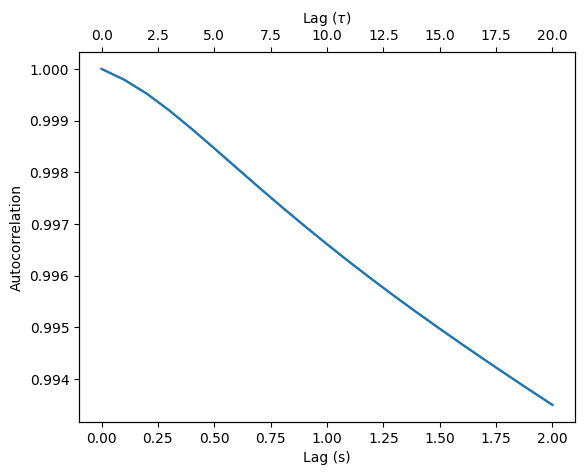

In [26]:
time_lags_hr, r_vec_hr = compute_nd_acf(np.array([wind_df_hr.BGSE_0, wind_df_hr.BGSE_1, wind_df_hr.BGSE_2]), nlags=20, dt = 0.1, show = True)

### Correlation scale functions

Names for $\tau_c$:
- Outer scale
- (Longitudinal) integral scale
- Correlation scale

Adapting Kevin's function for computing outer scale using exponential fit: from `compute_correlation_time_scale()`. A function of the following form is fit to the ACF $R(\tau)$.

$$f(\tau)=\exp(-\tau/\tau_c)$$

"The extent of the autocorrelation to fit on was determined to be 1000 seconds worth of lag, through some trial and error and inspection of plotted results" (de Lange, 2021). Kevin referred to the value calculated from this method as `lambda_c` and `Correlation_timescale`.

In [27]:
from utils import exp_fit

def compute_outer_scale_exp_fit(time_lags, acf, seconds_to_fit, show=False):

    dt = time_lags[1]-time_lags[0]
    num_lags_for_lambda_c_fit = int(seconds_to_fit/dt)
    c_opt, c_cov = curve_fit(
        exp_fit, time_lags[:num_lags_for_lambda_c_fit], acf[:num_lags_for_lambda_c_fit], p0=1000)
    lambda_c = c_opt[0]

    # Optional plotting
    if show == True:
        ax = plt.gca()
        #ax.set_ylim(-.2, 1.2)
        plt.plot(time_lags, acf, label = "Autocorrelation")
        plt.plot(
            np.array(range(int(seconds_to_fit))),
            exp_fit(
                np.array(range(int(seconds_to_fit))),
                *c_opt
            ),
            'r-', 
            label = "Exponential fit")
        # box_color = 'grey' if lambda_c > 50 else 'red'
        # ax.text(time_lags[-1]*(5/10), 0.9, f'$\lambda_c$: {round(lambda_c, 1)}s', style='italic', fontsize=10,
        #         bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        ax.set_xlabel('Lag (s)')
        #ax2.set_xlabel('Lag ($\\tau$)')
        plt.legend()
        plt.show()
    
    return lambda_c


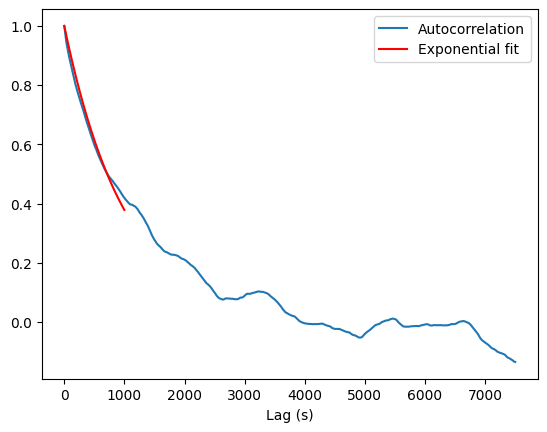

1027.3748653402208

In [28]:
compute_outer_scale_exp_fit(time_lags_lr, r_vec_lr, seconds_to_fit = 1000, show = True)

Using Kevin's function for computing outer scale using $1/e$ trick:

If we set $f(\tau)=\exp(-\tau/\tau_c)=e^{-1}$, then $\tau_c=\tau$.

Kevin referred to the value calculated from this method as `estimate` and `Correlation_timescale_est`.

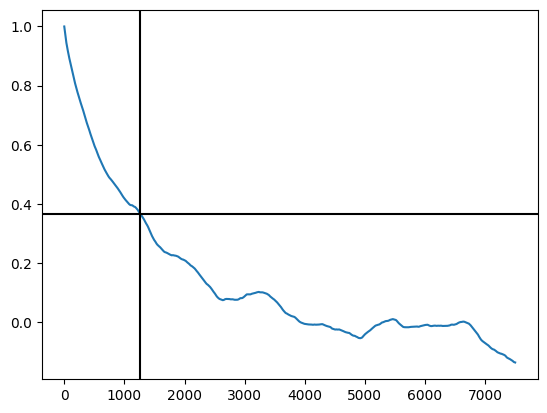

1258.615

In [29]:
# import importlib
# import utils
# importlib.reload(utils)
# lambda_outer_exp_trick = utils.estimate_correlation_scale(time_lags_lr, r_vec_lr, show = True)

from utils import estimate_correlation_scale as compute_outer_scale_exp_trick
compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, show = True)

Creating function for computing outer scale as integral of the (longitudinal) ACF. This formula comes from the re-arrangement of the simple exponential that a time series follows if it approximates a Markov process (Batchelor, 1970).

$$\tau_C=\int_0^\infty R(\tau)d\tau$$

In [30]:
def compute_outer_scale_integral(time_lags, acf):
    # Compute the area using the composite trapezoidal rule.
    area = np.trapz(y = acf, x = time_lags)
    print("Area (trapz) =", area)

    # Compute the area using the composite Simpson's rule.
    area = scipy.integrate.simps(y = acf, x = time_lags)
    print("Area (simps) =", area)

    return area

In [31]:
compute_outer_scale_integral(time_lags_lr, r_vec_lr)

Area (trapz) = 1012.3627132914291
Area (simps) = 1012.361886231482


1012.361886231482

### Taylor scale function

Taylor microscale (time domain) = $\tau_{TS}$ = radius of curvature of ACF at the origin. 

Can calculate using second derivative of the ACF at the origin, but this is not commonly done as it is very sensitive to behaviour at the origin. Here we use the parabolic fit method. This codes is adapted from Kevin's `compute_taylor_time_scale()`.

Previously this function took the number of seconds to fit the parabola over as the input, and then converted this to the number of lags. (This was chosen to be 2 seconds = 20 lags.) In line with Chuychai's method, this function now takes the number of lags `tau_fit` as input directly.

In [32]:
from utils import para_fit

def compute_taylor_scale(time_lags, acf, tau_fit, show=False):
    """Compute the Taylor microscale
    
    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_fit: number of lags to fit the parabola over
    """

    # If using seconds_fit as the fitting argument instead:

    # dt = time_lags[1]-time_lags[0]
    # tau_fit = int(seconds_fit/dt)

    t_opt, t_cov = curve_fit(
        para_fit,
        time_lags[:tau_fit],
        acf[:tau_fit],
        p0=10)
    lambda_t = (-1*t_opt[0])**-.5

    # Optional plotting
    if show == True:
        ax = plt.gca()
        ax.set_ylim(0, 1.2)
        plt.plot(time_lags, acf, label = "Autocorrelation", lw=2)
        plt.plot(
            np.array(range(int(1.2*lambda_t))),
            para_fit(np.array(range(int(1.2*lambda_t))), *t_opt),
            '-y',
            label = "Parabolic fit")
        #plt.axhline(0, color = 'black')
        ax.vlines(0, ymin = 0.95, ymax = 1.05, color = 'green')
        ax.vlines(tau_fit*(time_lags[1]-time_lags[0]), ymin = 0.92, ymax = 1.02, color = 'green')
        ax.set_xlabel('Lag (s)')
        #ax.set_xlabel('Lag ($\\tau$)')
        plt.legend()
        plt.show()

    return lambda_t


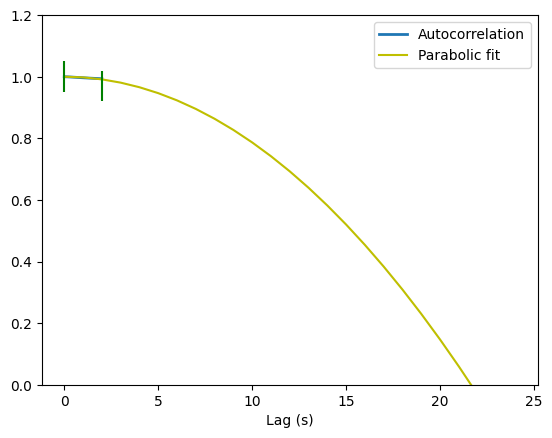

21.65367460188057

In [33]:
compute_taylor_scale(time_lags_hr, r_vec_hr, tau_fit=20, show = True)

#### Chuychai (Richardson) extrapolation method

Calculate Taylor scale from parabolic fit for a range of values of `tau_fit`. Plot these values as a function of `tau_fit`, then draw a straight line through the points back to `tau_fit`=0. For the ACE data, Chuychai et al. used the range $4<\tau_{fit}<25$

Chuychai's notation:
- $\tau_{fit}$: parabola is fitted from $\tau=0$ to $\tau=\tau_{fit}$
- $\tau_{fit}^{est}(\tau_{fit})$ = estimate of $\tau_{TS}$ for a given value of $\tau_{fit}$
- $\tau_{TS}^{extra}$: estimate obtained by the extrapolation method
- $q$ = dissipation scale index
- $\tau_{d}$ = Kolmogorov scale (time domain) - point where the inertial range terminates and the spectrum steepens

Chuychai et al. then developed an additional correction factor "which can be used when estimates of the [slope of the] high-frequency spectrum of the signal are available in some way, whether it be observations, theory, or an informed guess".

In [34]:
def compute_taylor_chuychai(time_lags, acf, tau_min, tau_max, show=False):
    """Compute a refined estimate of the Taylor microscale using a linear extrapolation method from Chuychai et al. (2014).
    
    Args:

    - time_lags: The x-values of the ACF, in seconds, given the cadence of measurements
    - acf: The y-values of the ACF
    - tau_min: Minimum value for the upper lag to fit the parabola over. This should not be too small, because the data has finite time resolution and there may be limited data available at the shortest time lags. (You will see divergent behaviour if this happens.)
    - tau_max: Maximum value for the upper lag to fit the parabola over
    """

    tau_fit = np.arange(tau_min, tau_max+1)
    tau_ts = np.array([])

    for i in tau_fit:
        lambda_t = compute_taylor_scale(time_lags, acf, tau_fit=i, show=False)
        tau_ts = np.append(tau_ts, lambda_t)

    # Performing linear extrapolation back to tau_fit = 0
    z = np.polyfit(x=tau_fit, y=tau_ts, deg=1)
    f = np.poly1d(z)

    other_x = np.arange(0, tau_max+1)
    other_y = f(other_x)

    # Optional plotting
    if show == True:
        plt.plot(tau_fit, tau_ts, color="blue", label = "Range over which $\\tau_{TS}$ was calculated")
        plt.plot(other_x, other_y, color="black", label = "Linear extrapolation to $\\tau_{fit}$=0", ls = '--')
        plt.xlim(0, 30)
        plt.xlabel("$\\tau_{fit}$")
        plt.ylabel("$\\tau_{TS}$")
        plt.legend()
        plt.show()

    return other_y[0]


We can compare the following to Fig. 4 in Chuychai.

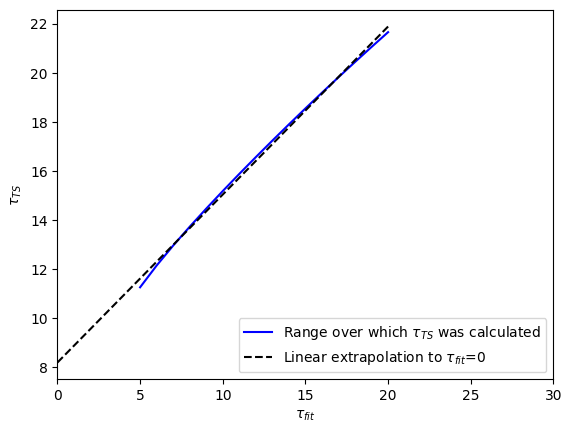

8.199186230748374

In [35]:
compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=5, tau_max=20, show = True)

Why can we not just calculate the $\tau_{TS}$ right up to the origin? Let's toggle `tau_min` right down:

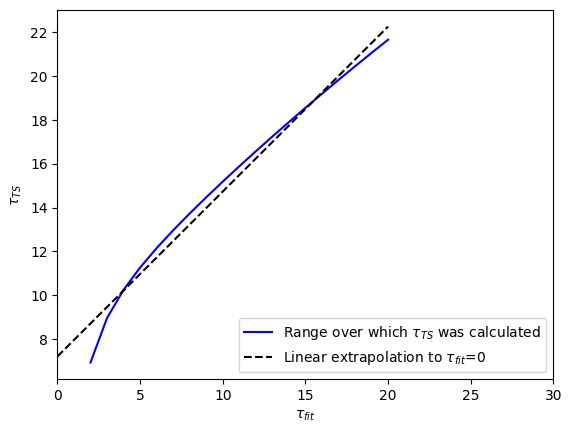

7.205958160567265

In [36]:
compute_taylor_chuychai(time_lags_hr, r_vec_hr, tau_min=2, tau_max=20, show = True)

As noted by Chuychai et al., "it is not practical to compute this limit because the data has a finite time resoluiton and there may be limited data available at the shortest time lags".

This paper also notes that we are more likely to reach a stable estimate of $\lambda_{TS}$ after extrapolation when we have a steep spectral index $q$ in the dissipation range. A smaller $q$ means we do not obtain a stable estimate.

## Final dataframe

In [ ]:
# joined_df = join_dataframes_on_timestamp(df1, df2)
# joined_df.head()